In [1]:
# We load the competition data

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/playground-series-s5e9/sample_submission.csv
/kaggle/input/playground-series-s5e9/train.csv
/kaggle/input/playground-series-s5e9/test.csv


# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Predicting the Beats-per-Minute of Songs

### Playground Series - Season 5, Episode 9

### Your Goal: 

The goal of this competition is to predict a song's beats-per-minute.

### Evaluation:

Submissions are evaluated using the Root Mean Squared Error between the predicted and the observed target.

### Submission File:

For each id in the test set, you must predict a continuous-valued BeatsPerMinute. The file should contain a header and have the following format:

    ID,BeatsPerMinute
    524164,119.5
    524165,127.42
    524166,111.11
    etc.

### Timeline:

- Start Date - September 1, 2025
- Entry Deadline - Same as the Final Submission Deadline
- Team Merger Deadline - Same as the Final Submission Deadline
- Final Submission Deadline - September 30, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

# Initial analysis

We'll start by loading the training data, and taking a first look to see what variables we have for this problem, as well as the number of samples.

In [3]:
# We load the data

bpm_train = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv", index_col="id")

In [4]:
bpm_train.shape

(524164, 10)

In [5]:
bpm_train.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [6]:
bpm_train.describe()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000


In [7]:
bpm_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                524164 non-null  float64
 1   AudioLoudness              524164 non-null  float64
 2   VocalContent               524164 non-null  float64
 3   AcousticQuality            524164 non-null  float64
 4   InstrumentalScore          524164 non-null  float64
 5   LivePerformanceLikelihood  524164 non-null  float64
 6   MoodScore                  524164 non-null  float64
 7   TrackDurationMs            524164 non-null  float64
 8   Energy                     524164 non-null  float64
 9   BeatsPerMinute             524164 non-null  float64
dtypes: float64(10)
memory usage: 44.0 MB


We faced a regression problem with the variable "BeatsPerMinute" to predict and nine features, all of which are numerical. We had 524164 training samples, and at first glance, we didn't detect any missing values. We found wide ranges of values, so we have to analyze for potential outliers. Next, we will perform our exploratory data analysis to understand the data in depth.

# EDA

We will conduct an individual exploration and analysis of each variable to understand their distributions and overall statistical values, thus gaining a complete picture of each feature. Additionally, we will seek out all the information regarding the meaning and context of each of them.

In [8]:
# Establishing the seaborn aesthetic

sns.set_style("darkgrid")

# We establish the color palette

palette = sns.set_palette("Greens_r")

In [9]:
# Function to analyze distribution

def plot_numeric(data, column, figsize, suptitle):

    print(
    "Variable: ", column,
    "\nFormat: ", data[column].dtype,
    "\nNumber of null values: ", data[column].isnull().sum(),
    "\nUnique values: ", data[column].nunique(),
    "\nVariable range:", data[column].min(), "to", data[column].max(), "\n\n"
    )

    # We graph the distribution
    
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    sns.histplot(
        data=data, 
        x=column, 
        palette=palette,
        edgecolor="k",
        kde=True,
        ax=axes[0]
    )
    sns.boxplot(
        data=data, 
        x=column,
        palette=palette,
        ax=axes[1]
    )
    plt.suptitle(t=suptitle)
    plt.tight_layout()
    plt.show()

## BeatsPerMinute (Target variable)

Beats Per Minute (BPM) is the standard measurement for a song's tempo, indicating the number of beats in one minute. A higher BPM signifies a faster song, while a lower BPM means a slower song. For example, a 60 BPM track has one beat per second, whereas a 120 BPM track has two beats per second.

- Beats per minute: BPM is the number of musical beats that occur in sixty seconds. 
- Tempo: BPM is the numerical representation of a song's tempo, which is the speed or pace of the music. 
- Higher BPM: A higher BPM value means there are more beats per minute, resulting in a faster, more energetic feel. 
- Lower BPM: A lower BPM value means fewer beats per minute, leading to a slower, more relaxed feel.

Variable:  BeatsPerMinute 
Format:  float64 
Number of null values:  0 
Unique values:  14622 
Variable range: 46.718 to 206.037 




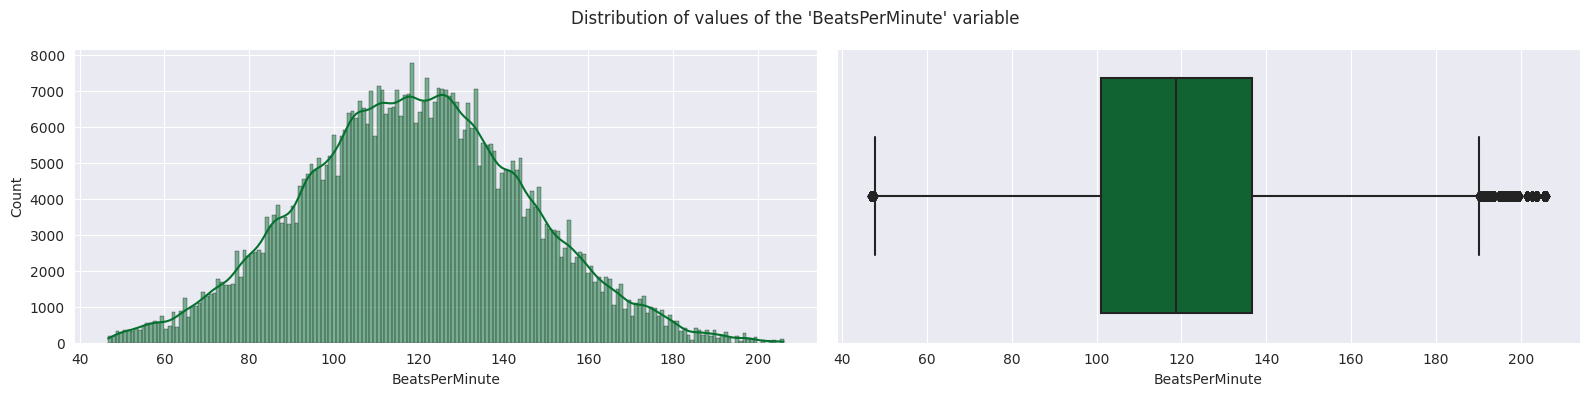

In [10]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "BeatsPerMinute", 
    (16, 4), 
    "Distribution of values of the 'BeatsPerMinute' variable"
)

The target variable has no missing or erroneous values. It has a bell-shaped, near-normal distribution with a mean of 119 BPM. The values range from 46 to 206 BPM.

## RhythmScore

A rhythm score variable isn't a standard musical term, but it generally refers to a quantifiable aspect of rhythm that can be measured or calculated, such as the note duration within a rhythmic pattern, the number of beats per measure, the combo multiplier in a rhythm game, or even the "rhythm accuracy" in a performance-based assessment. The specific meaning of a "rhythm score variable" depends on the context.

Variable:  RhythmScore 
Format:  float64 
Number of null values:  0 
Unique values:  322528 
Variable range: 0.0769 to 0.975 




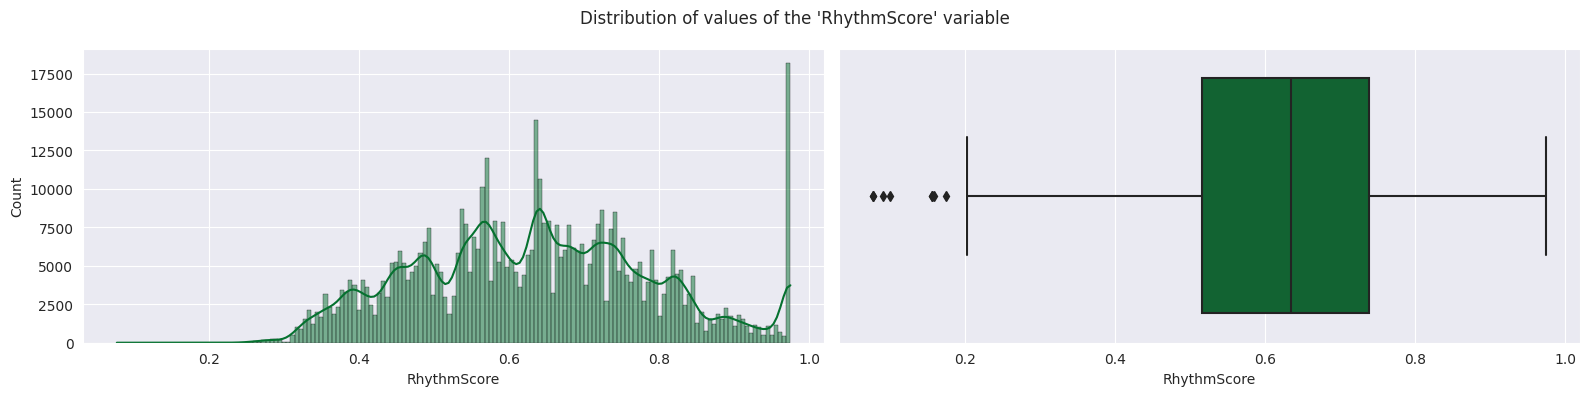

In [11]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "RhythmScore", 
    (16, 4), 
    "Distribution of values of the 'RhythmScore' variable"
)

The variable does not present null data, nor did we detect any errors. With an average of 0.632 and a median of 0.634, we find a negative or left-skewed distribution, with the mean being smaller. The bulk of the data is clustered toward the upper end of the value range, so we find outliers in the range of lower values.

## AudioLoudness

An Audio Loudness variable isn't a single, specific variable but refers to a measurement of audio perceived loudness, standardized in LUFS (Loudness Units relative to Full Scale) or LKFS. It's a crucial concept in audio engineering for normalizing volume across different programs, preventing jarring changes in perceived volume and ensuring a consistent listening experience for users. Instead of a variable in a programming sense, it's a meter reading or target level that producers use to adjust the dynamic range of their audio content.

Key aspects of Audio Loudness:

- Perceived Loudness: LUFS measures how loud an audio signal sounds to a human ear, not just its peak amplitude.
- Standardization: The LUFS standard is used by streaming services, broadcast platforms, and virtual reality environments to maintain consistent audio levels.
- Negative Values: Like decibels relative to full scale (dBFS), LUFS values are typically negative numbers, with values closer to 0 being louder.
- Normalization: This is the process of adjusting audio's overall volume to meet a specific target LUFS level, making it sound consistent with other programs.
- Dynamic Range: LUFS also helps manage the variation in loudness within a single piece of content (e.g., a movie or song), ensuring that loud moments aren't overwhelmingly so and quiet moments aren't inaudible.
- Tools: You can measure LUFS using tools like Digital Audio Workstations (DAWs) with integrated LUFS meters or command-line utilities like FFmpeg.

Variable:  AudioLoudness 
Format:  float64 
Number of null values:  0 
Unique values:  310411 
Variable range: -27.50972513 to -1.357 




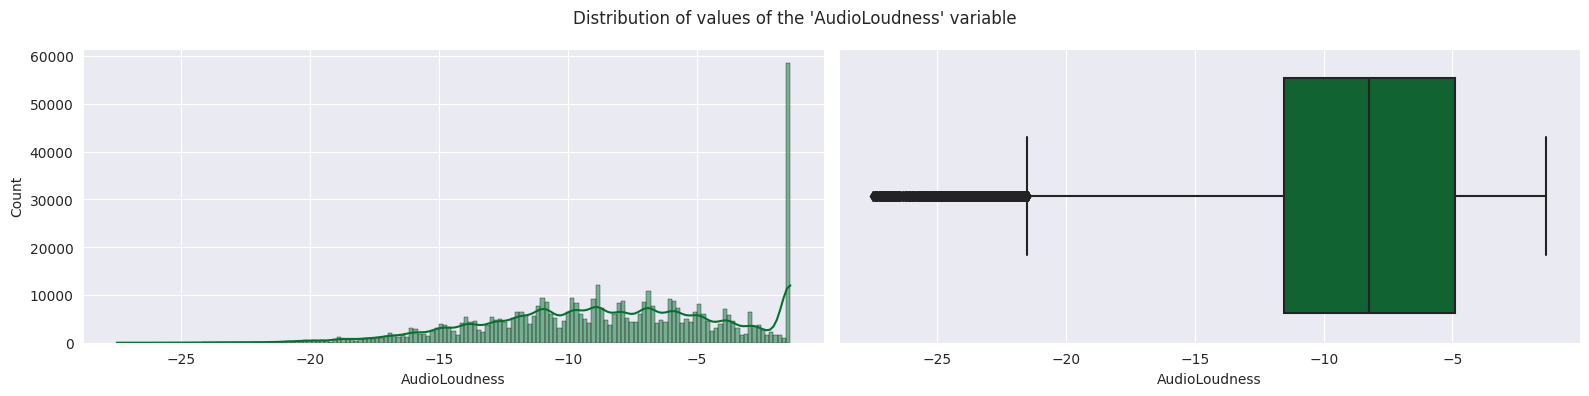

In [12]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "AudioLoudness", 
    (16, 4), 
    "Distribution of values of the 'AudioLoudness' variable"
)

We did not find any null or erroneous data in our initial analysis. The distribution has a pronounced left tail. We observed a concentration of samples at the highest value. However, we found data with a mean of -8.379 and a lower median of -8.2524. We detected a large number of outliers in the lower range of values.

## VocalContent

Vocal content as a variable refers to the use of specific elements within spoken or sung communication that can be manipulated or measured for various purposes, particularly in research, technology, or performance. These variables are distinct from the inherent qualities of a voice (like a person's unique vocal tract length or fundamental frequency) and instead focus on aspects that can change based on context, intent, or design. Some key aspects of vocal content as a variable are the acoustic parameters. This encompasses measurable features of sound, such as:

- Pitch: The perceived highness or lowness of a voice.
- Pace/Rate: The speed at which words are spoken.
- Loudness/Power: The intensity or volume of the voice.
- Pauses: Strategic silences within speech.
- Intonation: The rise and fall of pitch in speech, conveying meaning or emotion.
- Timbre/Tone: The unique quality of a voice that distinguishes it from others, even at the same pitch and loudness.

Variable:  VocalContent 
Format:  float64 
Number of null values:  0 
Unique values:  229305 
Variable range: 0.0235 to 0.256401015 




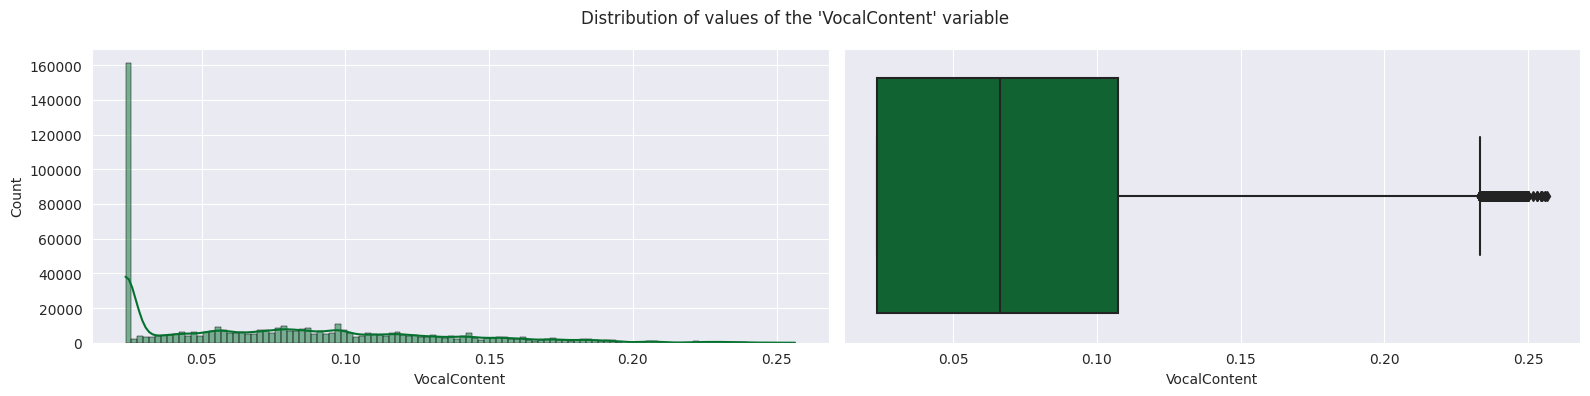

In [13]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "VocalContent", 
    (16, 4), 
    "Distribution of values of the 'VocalContent' variable"
)

The variable does not present null data nor do we observe erroneous data. The values are distributed within a range of 0.02 to 0.25. With a pronounced right tail or right skew, we find a mean of 0.074 and a lower median of 0.066. This variable presents outliers centered on the highest values, and a concentration of samples at the lowest value.

## AcousticQuality

An acoustic quality variable can refer to physical properties like pressure, density, and distance that describe a sound wave, or to a space's ability to be acoustically adjusted using technologies like curtains, panels, and electronic systems to control reverberation for different types of events. In the context of subjective experience, variables also include psychoacoustic and psychological factors, as listeners evaluate sound based on their expectations and subjective attitudes. Physical Acoustic Variables are fundamental properties of a sound wave that change as it travels through a médium:

- Pressure: The variation in the force exerted by the sound wave on the particles of the medium.
- Density: The change in the density of the medium's particles as the sound wave passes through.
- Distance: The physical space over which the wave travels.

Variable:  AcousticQuality 
Format:  float64 
Number of null values:  0 
Unique values:  270478 
Variable range: 5.36e-06 to 0.995 




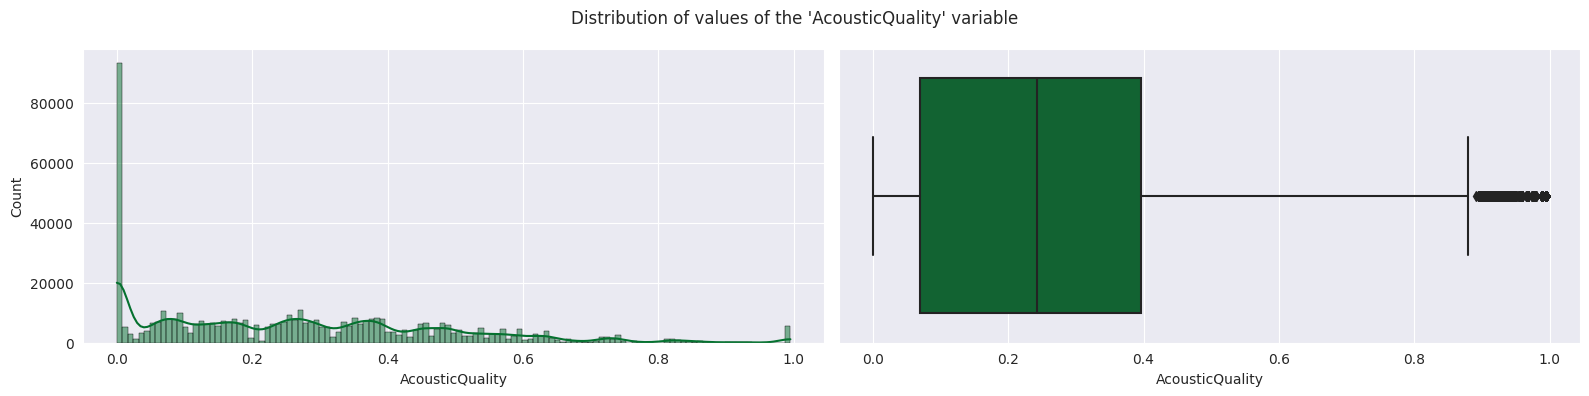

In [14]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "AcousticQuality", 
    (16, 4), 
    "Distribution of values of the 'AcousticQuality' variable"
)

We did not observe any null or erroneous data. The distribution is positive with a pronounced right tail or right skew. Again, as with the previous variable, we find a concentration of samples at the lowest value. The mean is around 0.26, and the logically lower median is around 0.24, in addition to the presence of outliers in the upper range.

## InstrumentalScore

In songs, an "instrumental score" refers to the written musical notation that specifies pitches, rhythms, dynamics, and other elements for an instrumental piece or an instrumental arrangement of a song. The term can also describe variables within the score that are manipulated to convey different emotions or characteristics, such as tempo, dynamics, or articulation. Additionally, "score" can refer to a numerical value used to quantify a musical attribute, like a "liveliness coefficient" or a complexity score, which are calculated from features extracted from the music.

Instrumental Score as a Numerical Value:

- Musical Metrics: In computational music analysis, a "score" can be a numerical value that quantifies a musical characteristic.
- Applications: These scores can be used in music information retrieval, for example, to predict hit songs or assess the difficulty level of a piece.

Variable:  InstrumentalScore 
Format:  float64 
Number of null values:  0 
Unique values:  218979 
Variable range: 1.07e-06 to 0.869257975 




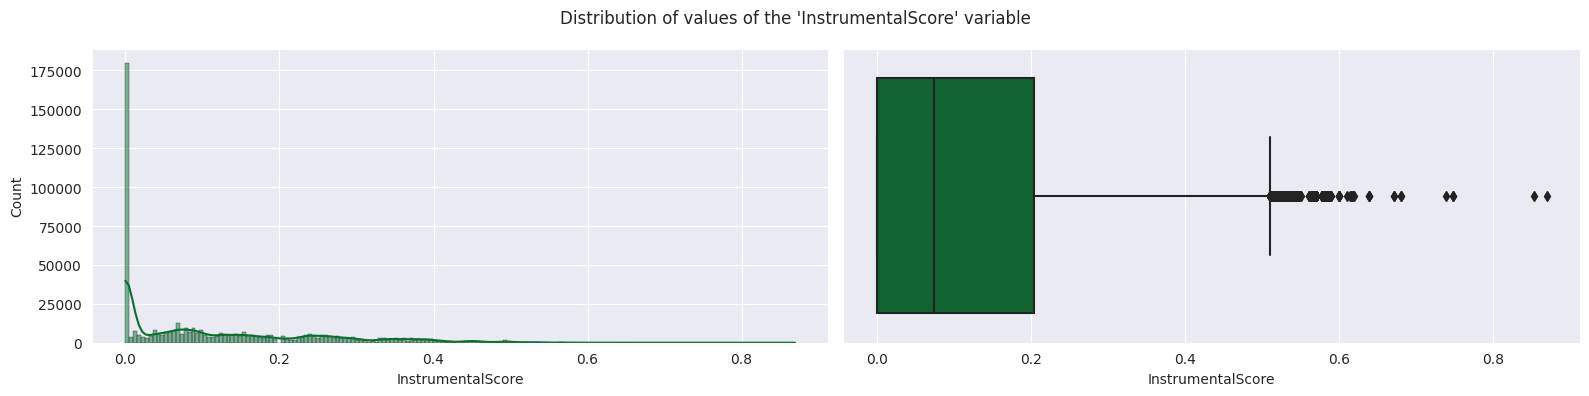

In [15]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "InstrumentalScore", 
    (16, 4), 
    "Distribution of values of the 'InstrumentalScore' variable"
)

There are no null or erroneous data. The variable has a right-skewed distribution, with a very pronounced tail, and the presence of many outliers in the highest range of values to be handled. With a mean of 0.117690 and a lower median of 0.074247, the variable has a large number of unique values. Most samples represent the lowest value.

## LivePerformanceLikelihood

The "Live Performance Likelihood" can refer to the audience's experience, it might describe the emotional and physiological impact of a live performance on an audience. Studies have shown that live performances can elicit strong emotional and physiological responses in audiences. The unique interaction between performers and the audience in a live setting contributes to this stronger emotional engagement, which cannot be fully replicated by digital recordings. As a note, in addition, it could also refer to statistical probability, it would involve calculating the chance of a live performance happening using a likelihood function. In statistics, the term "likelihood" refers to a function that measures how well a statistical model fits observed data. The likelihood function calculates the probability of observing a particular dataset given different values of a model's parameters.

Variable:  LivePerformanceLikelihood 
Format:  float64 
Number of null values:  0 
Unique values:  279591 
Variable range: 0.0243 to 0.599924031 




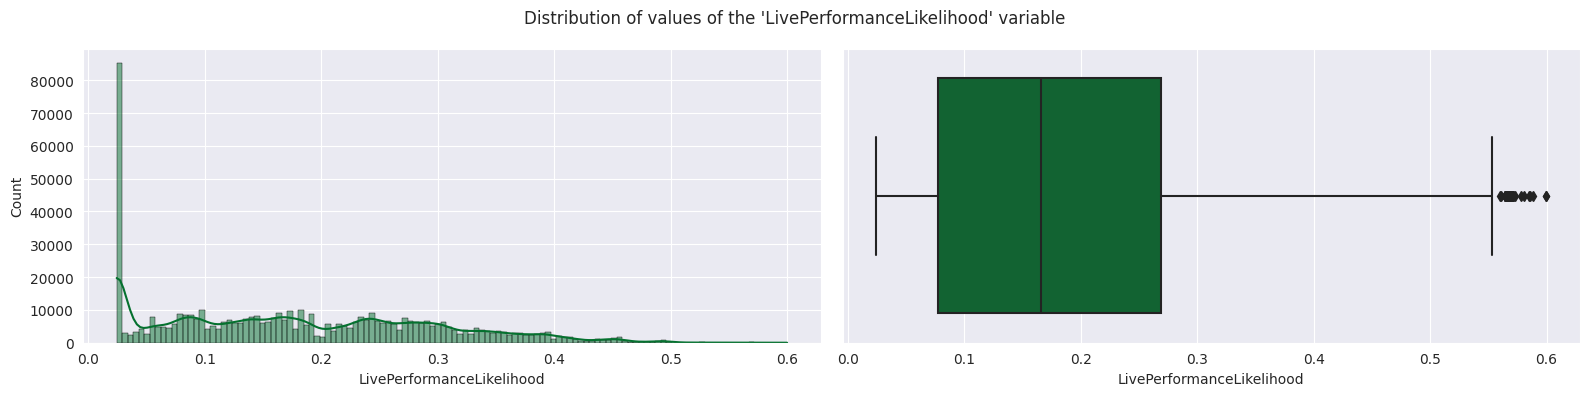

In [16]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "LivePerformanceLikelihood", 
    (16, 4), 
    "Distribution of values of the 'LivePerformanceLikelihood' variable"
)

Once again, there are no null or erroneous data. The distribution, as with the previous variables, has a very pronounced right tail, with the largest number of samples at the lowest value. The range of values is between 0.02 and 0.59, with a mean of 0.178398 and a median of 0.166327. Again, there are outliers in the higher range.

## MoodScore

A MoodScore variable is a quantitative measurement of a person's emotional state, used in various contexts like media testing, mental health assessments, and behavioral research to understand emotional impact, mood fluctuations, or general emotional well-being. It can represent a total score, like a media's emotional impact, or track changes in mood over time, often yielding values on a scale to facilitate comparison and analysis of individual and group differences in mood. Applications and Interpretations of MoodScore Variables
Media Testing
: A "MoodScore" can be used to evaluate the emotional response to advertisements or other media content, often measuring factors like cognitive ease, sympathy, and positive emotions to achieve a score out of 100. 

Variable:  MoodScore 
Format:  float64 
Number of null values:  0 
Unique values:  306504 
Variable range: 0.0256 to 0.978 




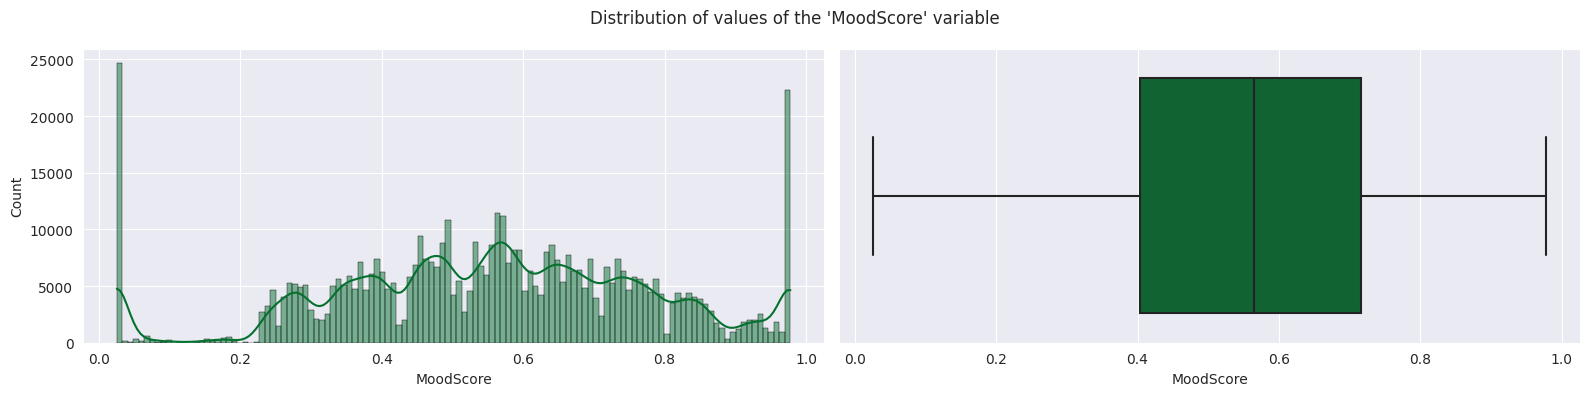

In [17]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "MoodScore", 
    (16, 4), 
    "Distribution of values of the 'MoodScore' variable"
)

We found no null or erroneous data. The distribution presents a large number of samples at the lowest and highest values, respectively. We observed a small, left-skewed tail, with a mean of 0.555843 and a slightly higher median of 0.564817. The values range from 0.02 to 0.97, with no extreme outliers.

## TrackDurationMs

Track Duration Ms refers to a task's total active working time expressed in milliseconds, a common unit in digital audio, project management, and software development. In digital audio, it often refers to a sound's length. Milliseconds (ms) are used to describe the precise timing of sound events, such as the length of a musical note or a sound effect. In a digital audio workstation (DAW), you can convert a song's beats per minute (BPM) into milliseconds (ms) to precisely time audio effects, like the attack and decay of a compressor. The formula is: 60,000 ms / BPM = duration of a quarter note (1 beat) in ms.

Variable:  TrackDurationMs 
Format:  float64 
Number of null values:  0 
Unique values:  377442 
Variable range: 63973.0 to 464723.2281 




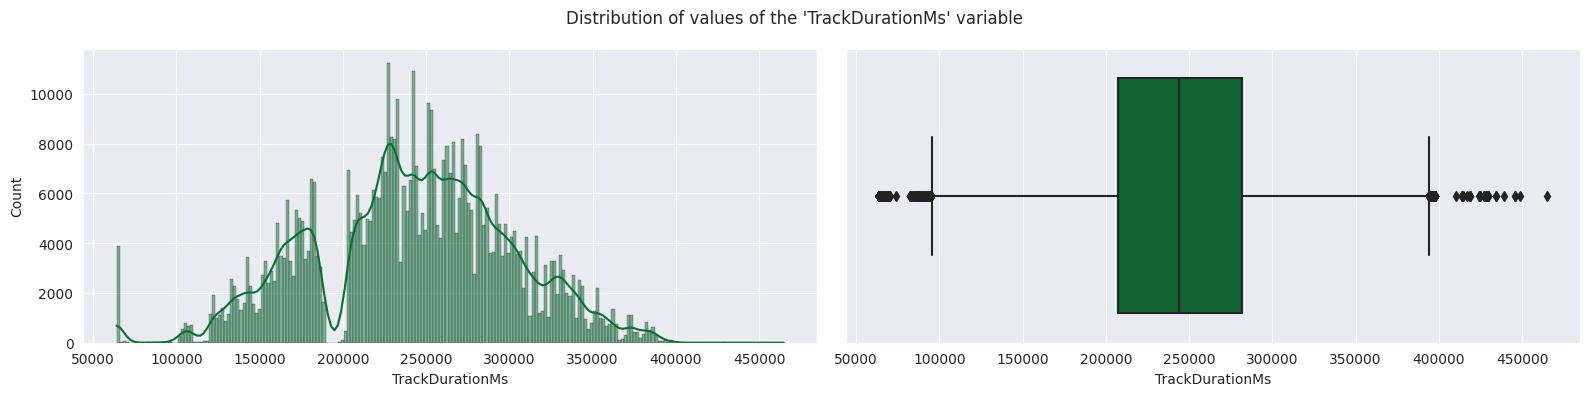

In [18]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "TrackDurationMs", 
    (16, 4), 
    "Distribution of values of the 'TrackDurationMs' variable"
)

Again, there were no erroneous or null data. The variable presents a large number of unique values with a wide range of values from 63973.0 to 464723.2281. The distribution presents the largest number of samples centered on the central values, with a mean of 241903.69 and a median, slightly higher, of 243684.058150. We observed the presence of outliers in both the low and high ranges of values.

## Energy

In songs, energy is a perceptible measure of intensity and activity. It's influenced by factors like tempo, dynamics (loudness variations), perceived loudness, timbre (instrumental texture), the rate of new musical events (onset rate), high-frequency content, and the overall entropy of the track. High-energy songs often feel fast, loud, and noisy, while low-energy songs are typically slower and more subtle. 

Key Factors Contributing to Energy:

- Tempo/Speed: The faster the tempo or the quicker the song's overall pace, the more energetic it feels. 
- Dynamics/Perceived Loudness: Significant shifts between loud and quiet sections, and a generally higher overall volume, contribute to a track's energy.
- Onset Rate: How often new sounds, like drum hits or synth lines, are introduced can increase the feeling of activity and energy. 
- Timbre: The quality or character of a sound, which can be achieved through instrumentation and effects like overdrive, plays a role in the perceived energy.
- High-Frequency Content: The presence of high-frequency elements, often found in percussion, can give a track a sense of brightness and energy.
- Entropy: The general "noisiness" or complexity of the music, including its texture and density, is related to its energy level.
- Tension and Release: The use of contrast between quiet and loud, dark and bright sounds, or the interplay of tension and its subsequent release, can create a feeling of energy.

Variable:  Energy 
Format:  float64 
Number of null values:  0 
Unique values:  11606 
Variable range: 6.67e-05 to 1.0 




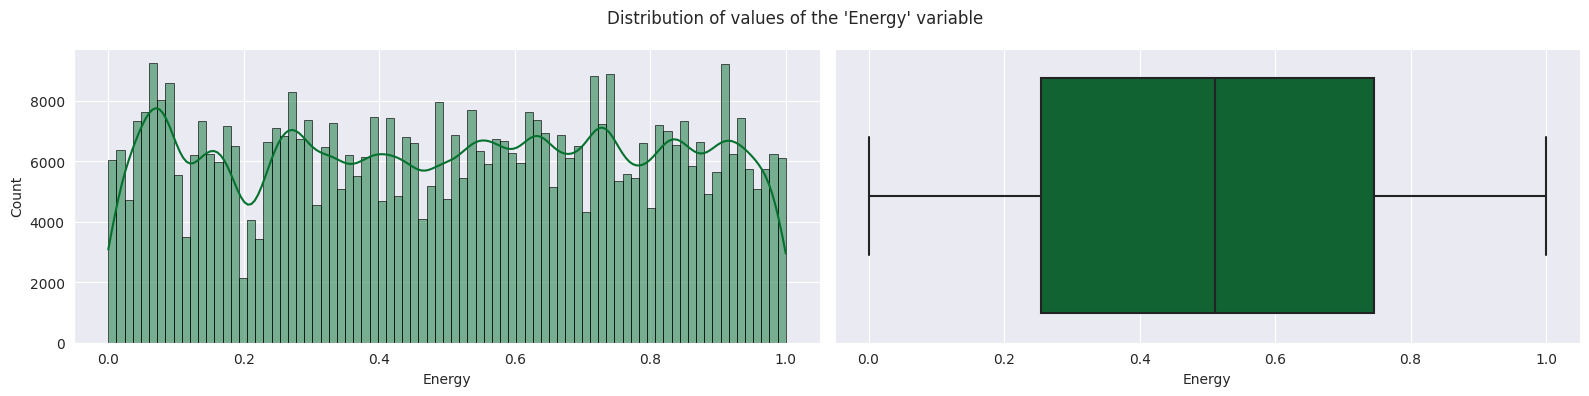

In [19]:
# We print and graph the distribution

plot_numeric(
    bpm_train, 
    "Energy", 
    (16, 4), 
    "Distribution of values of the 'Energy' variable"
)

We found no null or erroneous values. The distribution is almost evenly distributed across the entire range of values, with an even number of samples and few unique values compared to the previous variables. No outliers were observed, with a mean of 0.500923 and a median of 0.511800, which is slightly higher.

We have finished performing the exploratory data analysis, next we will manage the data to be able to ask some interesting questions with which to explore the data in greater depth, and obtain a greater amount of insights.